## Imports

In [2]:
import math

import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics

## Load data

In [3]:
data_xlsx = pd.ExcelFile('data.xlsx')
co2_df = pd.read_excel(data_xlsx, 0)
temp_df = pd.read_excel(data_xlsx, 1)
temp_df = temp_df[1:]  # we have one extra year of data for the temperature at the start
temp_df.reset_index(drop=True, inplace=True)

In [4]:
co2_df.columns = ['year', 'y']
temp_df.columns = ['year', 'y']

## Graphing & Pre-Analysis

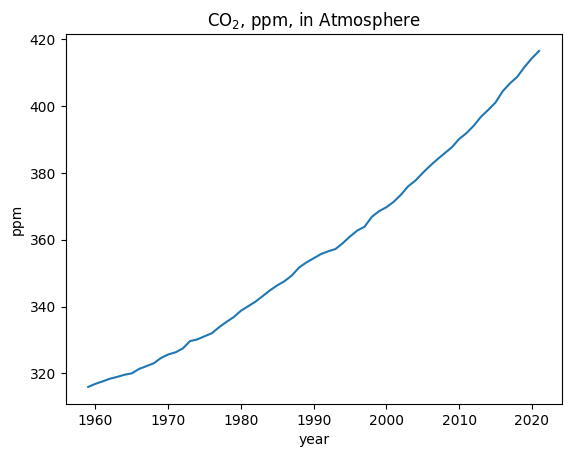

In [5]:
co2_gr = co2_df.plot(x='year', y='y', ylabel='ppm', title='CO$_2$, ppm, in Atmosphere', legend=None)

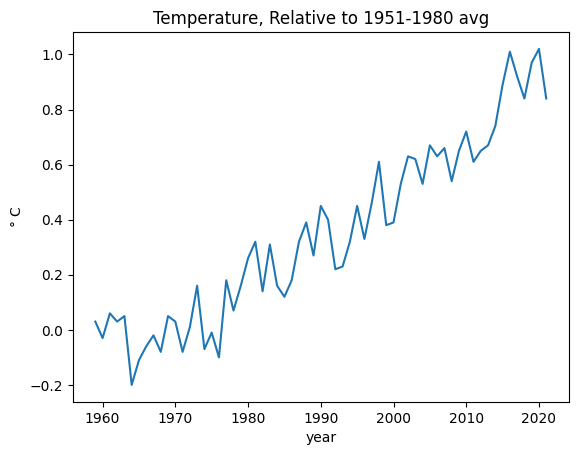

In [6]:
temp_gr = temp_df.plot(x='year', y='y', ylabel='$\degree$ C', title='Temperature, Relative to 1951-1980 avg', legend=None)

In [7]:
ct_df = pd.concat([co2_df['y'], temp_df['y']], axis=1, keys=['co2', 'temp'])


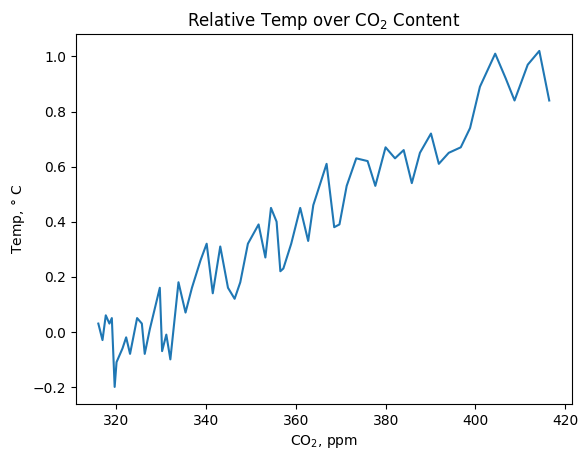

In [8]:
ct_gr = ct_df.plot(x='co2', y='temp', xlabel='CO$_2$, ppm', ylabel='Temp, $\degree$ C', title='Relative Temp over CO$_2$ Content',
                   legend=None)

In [9]:
_ = co2_gr.figure
_.figure.set_figwidth(8)
_.figure.set_figheight(6)
_.savefig('co2.png', bbox_inches='tight', dpi=330)

_ = temp_gr.figure
_.figure.set_figwidth(8)
_.figure.set_figheight(6)
_.savefig('temp.png', bbox_inches='tight', dpi=330)

_ = ct_gr.figure
_.figure.set_figwidth(8)
_.figure.set_figheight(6)
_.savefig('ct.png', bbox_inches='tight', dpi=330)

## Simple Bi variate Analysis

In [10]:
def bivariate_stats(x: pd.Series, y: pd.Series):
    _pmcc = x.corr(y)
    _covr = x.cov(y)

    print(
            f'PMCC: {_pmcc} \n'
            f'r^2:  {_pmcc ** 2} \n'
            f'Cov:  {_covr}'
    )


def univariate_graphs(x: pd.Series):
    pd.plotting.autocorrelation_plot(x)
    plt.show()


def linear_reg_func(m: LinearRegression):
    _coef = m.coef_[0][0]
    _itcp = m.intercept_[0]
    print(f'Linear Regressed: y = {_coef}x {"+" if abs(_itcp) == _itcp else "-"} {abs(_itcp)}')

### CO2

PMCC: 0.9911930941405609 
r^2:  0.9824637498719389 
Cov:  542.3161290322582


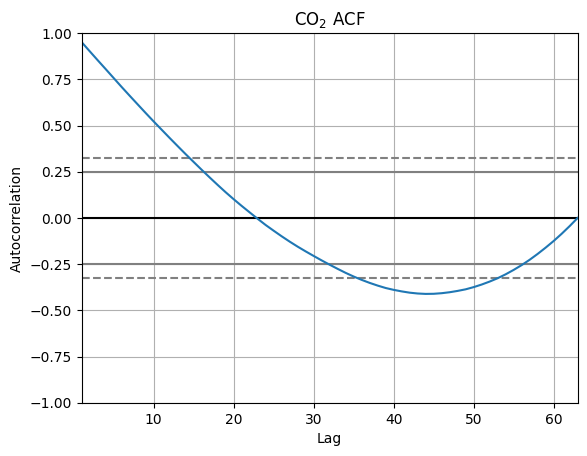

In [11]:
bivariate_stats(co2_df['year'], co2_df['y'])
_ = pd.plotting.autocorrelation_plot(co2_df['y'])
_.set_title('CO$_2$ ACF')

_ = plt.figure(1, figsize=(8, 6))

plt.show()

_.savefig('co2_acf.png', bbox_inches='tight', dpi=330)

### Temperature

PMCC: 0.9477123036837343 
r^2:  0.8981586105535305 
Cov:  5.650967741935484


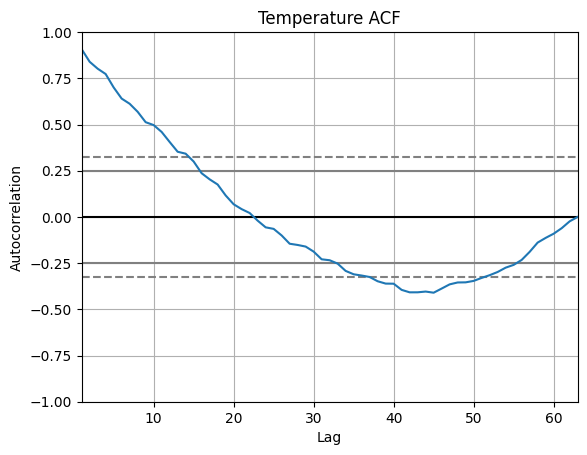

In [12]:
bivariate_stats(temp_df['year'], temp_df['y'])
_ = pd.plotting.autocorrelation_plot(temp_df['y'])
_.set_title('Temperature ACF')

_ = plt.figure(1, figsize=(8, 6))

plt.show()

_.savefig('temp_acf.png', bbox_inches='tight', dpi=330)

### Temperature over CO2 Content

In [13]:
ct_m_lr = LinearRegression()
ct_m_lr.fit(ct_df[['co2']], ct_df[['temp']])

ct_pred_l = ct_m_lr.predict(ct_df[['co2']])

In [14]:
bivariate_stats(ct_df['co2'], ct_df['temp'])

PMCC: 0.961318248780683 
r^2:  0.924132775438759 
Cov:  9.334014516129027


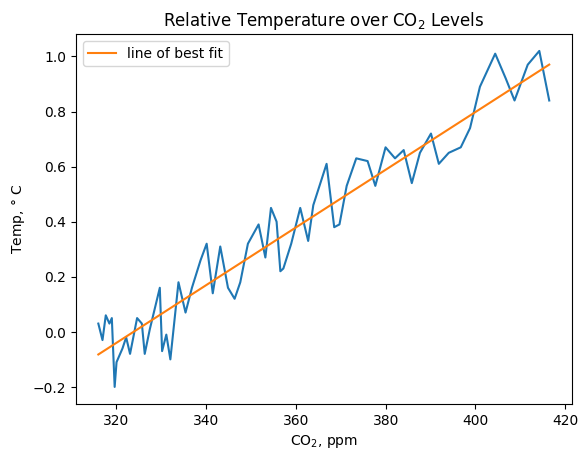

Linear Regressed: y = 0.010476572976201729x - 3.392572509671991


In [15]:
plt.plot(ct_df[['co2']], ct_df[['temp']])
plt.plot(ct_df[['co2']], ct_pred_l, label='line of best fit')
plt.title('Relative Temperature over CO$_2$ Levels')
plt.ylabel('Temp, $\degree$ C')
plt.xlabel('CO$_2$, ppm')
plt.legend()
_ = plt.figure(1, figsize=(8, 6))
plt.show()

_.savefig('ct2.png', bbox_inches='tight', dpi=330)

linear_reg_func(ct_m_lr)

## CO2 Forecasting

In [16]:
PRED_YEARS = pd.DataFrame(range(1959, 2051))
PRED_YEARS.columns = ['year']

In [17]:
PRED_YEARS_PROPHET = PRED_YEARS.copy()
PRED_YEARS_PROPHET.columns = ['ds']
PRED_YEARS_PROPHET['ds'] = pd.to_datetime(PRED_YEARS_PROPHET['ds'], format='%Y')

In [18]:
def error_stats(x: pd.Series, y: pd.Series):
    _mse = metrics.mean_squared_error(x, y)
    _mae = metrics.mean_absolute_error(x, y)
    _mape = metrics.mean_absolute_percentage_error(x, y)
    _r2 = metrics.r2_score(x, y)

    print(
            f'MSE:  {_mse} \n'
            f'RMSE: {math.sqrt(_mse)} \n'
            f'R^2:  {_r2} \n'
            f'MAE:  {_mae} \n'
            f'MAPE: {_mape}%'
    )

### Linear

In [19]:
def line_func(x, a, b):
    return a * x + b

In [20]:
m_co2_lr = LinearRegression()

m_co2_lr.fit(co2_df[['year']], co2_df[['y']])
pmt_co2_line = [m_co2_lr.coef_, m_co2_lr.intercept_]

co2_pred_lr = m_co2_lr.predict(PRED_YEARS)
co2_pred_lr = pd.DataFrame(co2_pred_lr)
co2_pred_lr.columns = ['y']

In [21]:
bivariate_stats(co2_df['y'], co2_pred_lr['y'])
error_stats(co2_df['y'], co2_pred_lr['y'][:63])

PMCC: 0.9911930941405603 
r^2:  0.9824637498719377 
Cov:  875.317808953966
MSE:  15.375778036232472 
RMSE: 3.921195995641186 
R^2:  0.9824637498719381 
MAE:  3.276643990929686 
MAPE: 0.009183067163843218%


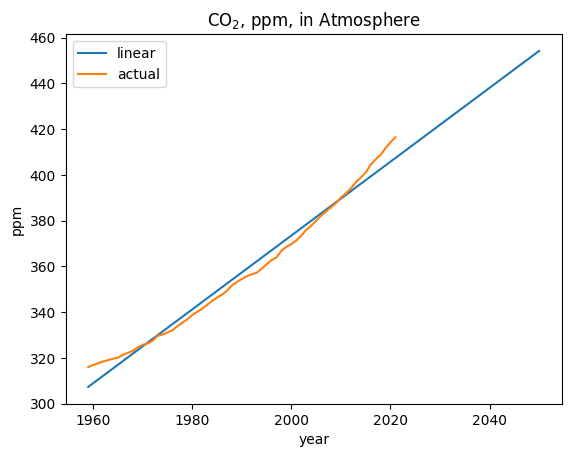

In [22]:
plt.plot(PRED_YEARS, co2_pred_lr, label='linear')
plt.plot(co2_df['year'], co2_df['y'], label='actual')
plt.title('CO$_2$, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
_ = plt.figure(1, figsize=(8, 6))
plt.show()

_.savefig('co2_line.png', bbox_inches='tight', dpi=330)

### Exponential

In [23]:
from scipy.optimize import curve_fit


In [24]:
def exp_func(x, a, b, c):
    return 2 ** ((x + a) * b) + c

In [25]:
pmt_co2_exp, cov = curve_fit(exp_func, co2_df['year'], co2_df['y'], p0=[-1727, 0.017, 264])
print(pmt_co2_exp)

[-1.70769063e+03  2.33806849e-02  2.56024002e+02]


In [26]:
co2_pred_exp = exp_func(PRED_YEARS, *pmt_co2_exp)
co2_pred_exp.columns = ['y']

In [27]:
bivariate_stats(co2_df['y'], co2_pred_exp['y'])
error_stats(co2_df['y'], co2_pred_exp['y'][:63])

print(f'Exponential Regressed: y = e^((x - {abs(pmt_co2_exp[0]):.5}) * {pmt_co2_exp[1]:.5}) + {pmt_co2_exp[2]:.5}')

PMCC: 0.9997258887013533 
r^2:  0.9994518525397106 
Cov:  890.4532160867481
MSE:  0.48061550325619284 
RMSE: 0.6932643819324579 
R^2:  0.9994518525397112 
MAE:  0.5698110006087824 
MAPE: 0.0016425839136093047%
Exponential Regressed: y = e^((x - 1707.7) * 0.023381) + 256.02


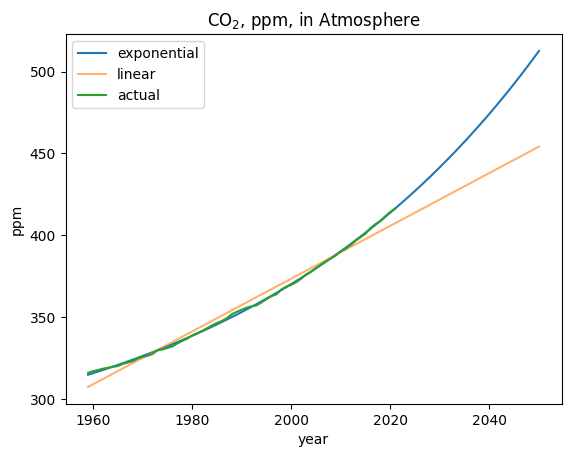

In [28]:
plt.plot(PRED_YEARS, co2_pred_exp, label='exponential')
plt.plot(PRED_YEARS, co2_pred_lr, label='linear', alpha=0.6)
plt.plot(co2_df['year'], co2_df['y'], label='actual')
plt.title('CO$_2$, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
_ = plt.figure(1, figsize=(8, 6))
plt.show()

_.savefig('co2_exp.png', bbox_inches='tight', dpi=330)

### Logistic

In [29]:
def logi_func(x, a, x0, k, d):
    return a / (1 + np.exp(-k * (x - x0))) + d

In [30]:
pmt_co2_logi, cov = curve_fit(logi_func, co2_df['year'], co2_df['y'], p0=[100, 2050, 0.005, 300])
print(pmt_co2_logi)

[2.52091731e+03 2.17544560e+03 1.75890111e-02 2.60022265e+02]


In [31]:
co2_pred_logi = logi_func(PRED_YEARS, *pmt_co2_logi)
co2_pred_logi.columns = ['y']

In [32]:
bivariate_stats(co2_df['y'], co2_pred_logi['y'])
error_stats(co2_df['y'], co2_pred_logi['y'][:63])
print(
        f'Logistic Regressed: '
        f'{pmt_co2_logi[0]:.5} / '
        f'(1 + '
        f'e^(-{pmt_co2_logi[2]:.5} * (x - {pmt_co2_logi[1]:.5}))'
        f') + {pmt_co2_logi[3]}'
)

PMCC: 0.9997263684050746 
r^2:  0.9994528116843988 
Cov:  890.4538867307685
MSE:  0.4797745259154965 
RMSE: 0.69265758200968 
R^2:  0.9994528116839551 
MAE:  0.5728657239279656 
MAPE: 0.0016480490200984055%
Logistic Regressed: 2520.9 / (1 + e^(-0.017589 * (x - 2175.4))) + 260.02226454456667


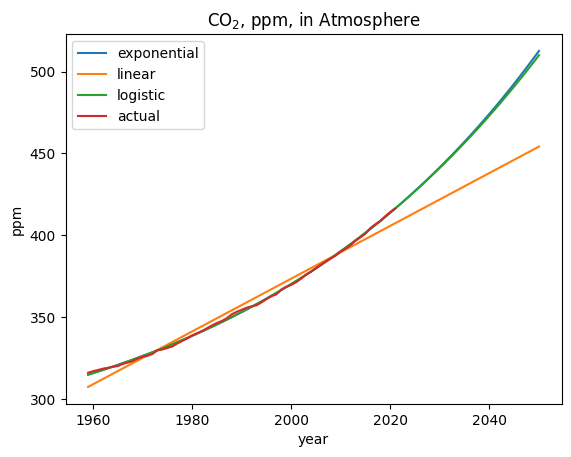

In [33]:
plt.plot(PRED_YEARS, co2_pred_exp, label='exponential')
plt.plot(PRED_YEARS, co2_pred_lr, label='linear')
plt.plot(PRED_YEARS, co2_pred_logi, label='logistic')
plt.plot(co2_df['year'], co2_df['y'], label='actual')
plt.title('CO$_2$, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
plt.show()

In [34]:
PRED_YEARS_MORE = pd.DataFrame(range(1959, 2401))
co2_pred_logi2 = logi_func(PRED_YEARS_MORE, *pmt_co2_logi)
co2_pred_logi2.columns = ['y']

C:\Users\yiqia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


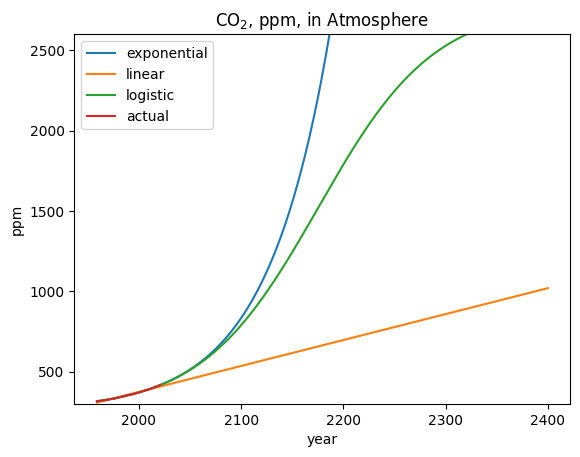

In [35]:
plt.plot(PRED_YEARS_MORE, exp_func(PRED_YEARS_MORE, *pmt_co2_exp), label='exponential')
plt.plot(PRED_YEARS_MORE, m_co2_lr.predict(PRED_YEARS_MORE), label='linear')
plt.plot(PRED_YEARS_MORE, co2_pred_logi2, label='logistic')
plt.plot(co2_df['year'], co2_df['y'], label='actual')
plt.title('CO$_2$, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.ylim(300, 2600)
plt.legend()
plt.show()

### Sigmoid

In [36]:
PRED_YEARS_MORE = pd.DataFrame(range(1959, 2101))

In [37]:
def sigm_func(x, slope, exp, x_ctr, y_min, y_max):
    return ((x - x_ctr) / (
            slope**-exp + (2 * abs(x - x_ctr) / (y_max - y_min))**exp
    ) ** (1 / exp)) + (y_max - y_min) / 2 + y_min


optim_pmt_man = [2.43825194334, 1.6, 2019.4, 262, 565]


def sigm_func_lim(y_max=565):
    def wrap(x, slope, exp, x_ctr, y_min):
        return sigm_func(x, slope, exp, x_ctr, y_min, y_max)
    return wrap

In [38]:
pmt_co2_sigm, cov = curve_fit(sigm_func_lim(), co2_df['year'], co2_df['y'], p0=optim_pmt_man[:-1], maxfev=69420)
print(pmt_co2_sigm)

[2.27964305e+00 1.49529625e+00 2.01676544e+03 2.46486529e+02]


In [39]:
co2_pred_sigm = sigm_func(PRED_YEARS, *pmt_co2_sigm, 565)
co2_pred_sigm.columns = ['y']

In [40]:
bivariate_stats(co2_df['y'], co2_pred_sigm['y'])
error_stats(co2_df['y'], co2_pred_sigm['y'][:63])

PMCC: 0.9996522037077992 
r^2:  0.9993045283778592 
Cov:  889.8656748570171
MSE:  0.6100239150323364 
RMSE: 0.7810402774712303 
R^2:  0.9993042607708762 
MAE:  0.6635074744320414 
MAPE: 0.001870789588942886%


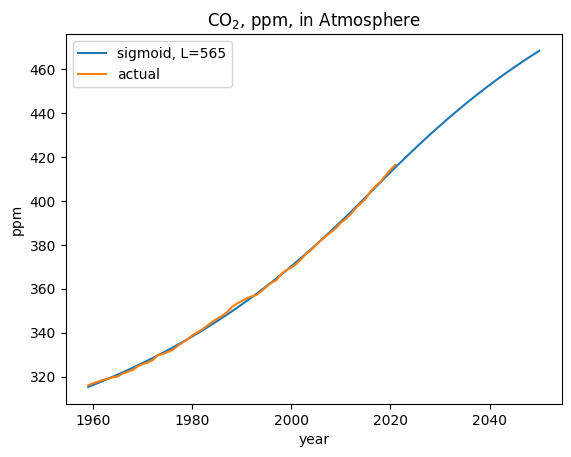

In [41]:
plt.plot(PRED_YEARS, co2_pred_sigm, label='sigmoid, L=565')
plt.plot(co2_df['year'], co2_df['y'], label='actual')
plt.title('CO$_2$, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
_ = plt.figure(1, figsize=(8, 6))
plt.show()

_.savefig('co2_sigm_565.png', bbox_inches='tight', dpi=330)

In [42]:
def sigm_fit_lim(lim):
    pmts, _ = curve_fit(sigm_func_lim(lim), co2_df['year'], co2_df['y'], p0=optim_pmt_man[:-1], maxfev=69420)
    return list(pmts) + [lim]

In [43]:
pmtS_co2_sigm = {lim_ : sigm_fit_lim(lim_) for lim_ in range(420, 961, 10)}

C:\Users\yiqia\AppData\Local\Temp\ipykernel_5096\339642217.py:3: RuntimeWarning: invalid value encountered in double_scalars
  slope**-exp + (2 * abs(x - x_ctr) / (y_max - y_min))**exp


In [44]:
co2_predS_sigm = {lim_ : sigm_func(PRED_YEARS_MORE, *pmtS_co2_sigm[lim_]) for lim_ in pmtS_co2_sigm.keys()}

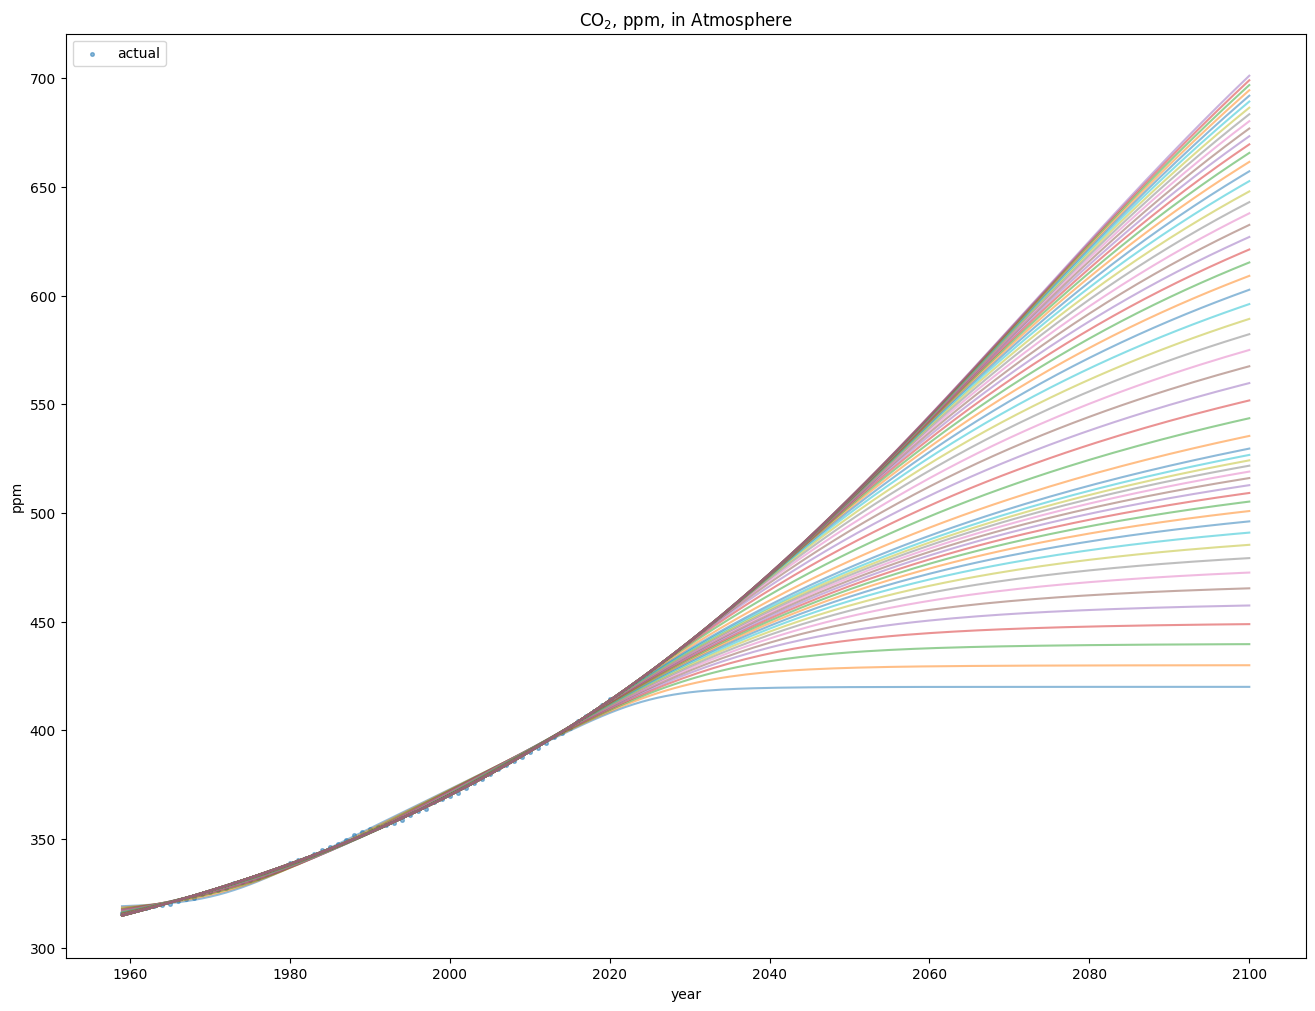

In [45]:
plt.figure(figsize=(16, 12))
for lim_, pred in co2_predS_sigm.items():
    plt.plot(PRED_YEARS_MORE, pred, alpha=0.5)
plt.scatter(co2_df['year'], co2_df['y'], label='actual', s=7, alpha=0.5)
plt.title('CO$_2$, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend(loc='upper left')

plt.savefig('co2_sigm_all.png', bbox_inches='tight', dpi=560)
plt.show()

C:\Users\yiqia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


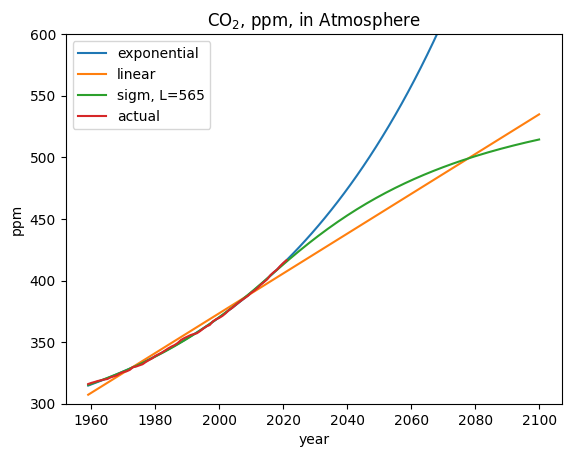

In [46]:
plt.plot(PRED_YEARS_MORE, exp_func(PRED_YEARS_MORE, *pmt_co2_exp), label='exponential')
plt.plot(PRED_YEARS_MORE, m_co2_lr.predict(PRED_YEARS_MORE), label='linear')
plt.plot(PRED_YEARS_MORE, sigm_func(PRED_YEARS_MORE, *pmt_co2_sigm, 565), label='sigm, L=565')
plt.plot(co2_df['year'], co2_df['y'], label='actual')
plt.title('CO$_2$, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.ylim(bottom=300, top=600)
plt.legend()
_ = plt.figure(1, figsize=(8, 6))
plt.show()

_.savefig('co2_sigm_lin_exp.png', bbox_inches='tight', dpi=330)

### Prophet

In [47]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [48]:
co2_df2 = co2_df.copy()
co2_df2.columns = ['ds', 'y']
co2_df2['ds'] = pd.to_datetime(co2_df2.ds, format='%Y')

In [49]:
m_co2_P = Prophet(yearly_seasonality=False)
m_co2_P.fit(co2_df2)

16:43:27 - cmdstanpy - INFO - Chain [1] start processing
16:43:27 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
co2_forecast_df = m_co2_P.predict(PRED_YEARS_PROPHET.copy())
co2_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1959-01-01,316.154264,315.744641,316.581320,316.154264,316.154264,0.0,0.0,0.0,0.0,0.0,0.0,316.154264
1,1960-01-01,316.852419,316.433548,317.309754,316.852419,316.852419,0.0,0.0,0.0,0.0,0.0,0.0,316.852419
2,1961-01-01,317.552487,317.138093,317.978746,317.552487,317.552487,0.0,0.0,0.0,0.0,0.0,0.0,317.552487
3,1962-01-01,318.244058,317.832226,318.677774,318.244058,318.244058,0.0,0.0,0.0,0.0,0.0,0.0,318.244058
4,1963-01-01,318.935629,318.524532,319.334420,318.935629,318.935629,0.0,0.0,0.0,0.0,0.0,0.0,318.935629
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2046-01-01,475.668703,462.970651,487.834774,462.741592,487.767991,0.0,0.0,0.0,0.0,0.0,0.0,475.668703
88,2047-01-01,478.049240,464.367120,490.807328,464.385822,490.847537,0.0,0.0,0.0,0.0,0.0,0.0,478.049240
89,2048-01-01,480.429777,465.641114,494.135560,465.838685,493.833737,0.0,0.0,0.0,0.0,0.0,0.0,480.429777
90,2049-01-01,482.816835,467.266445,497.047092,467.256982,497.015058,0.0,0.0,0.0,0.0,0.0,0.0,482.816835


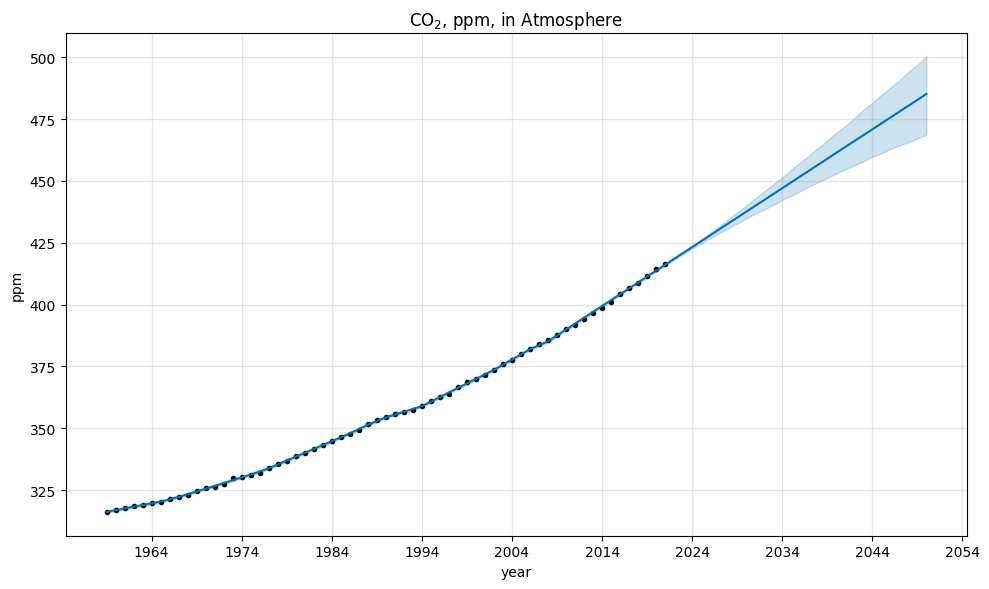

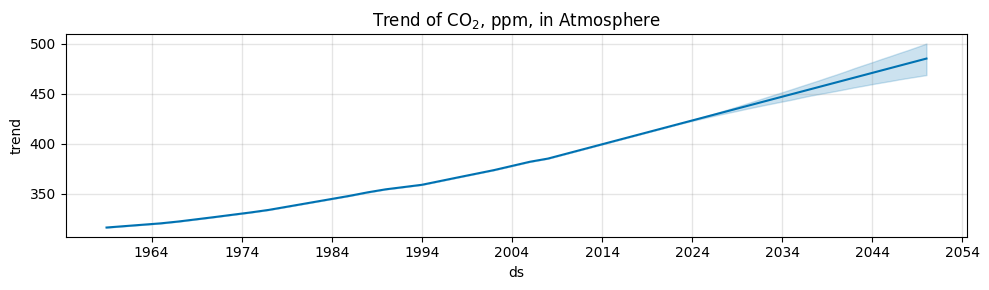

In [51]:
fig = m_co2_P.plot(co2_forecast_df, figsize=(10, 6), xlabel='year', ylabel='ppm')
fig.axes[0].set_title('CO$_2$, ppm, in Atmosphere')
fig.tight_layout()
fig.savefig('co2_prophet.png', dpi=330)

# _.savefig('co2_exp.png', bbox_inches='tight', dpi=330)

fig2 = m_co2_P.plot_components(co2_forecast_df, figsize=(10, 3))
fig2.axes[0].set_title('Trend of CO$_2$, ppm, in Atmosphere')
fig2.tight_layout()
fig2.savefig('co2_trend.png', dpi=330)

In [52]:
co2_pred_prophet = co2_forecast_df.copy()
co2_pred_prophet = co2_pred_prophet[['yhat']]
co2_pred_prophet.columns = ['y']

In [53]:
bivariate_stats(co2_df['y'], co2_pred_prophet['y'])
error_stats(co2_df['y'], co2_pred_prophet['y'][:63])

PMCC: 0.9999412069035434 
r^2:  0.999882417263715 
Cov:  890.8161713665066
MSE:  0.10309700037217488 
RMSE: 0.32108721614566793 
R^2:  0.9998824166958108 
MAE:  0.255074231747799 
MAPE: 0.0007003927564841805%


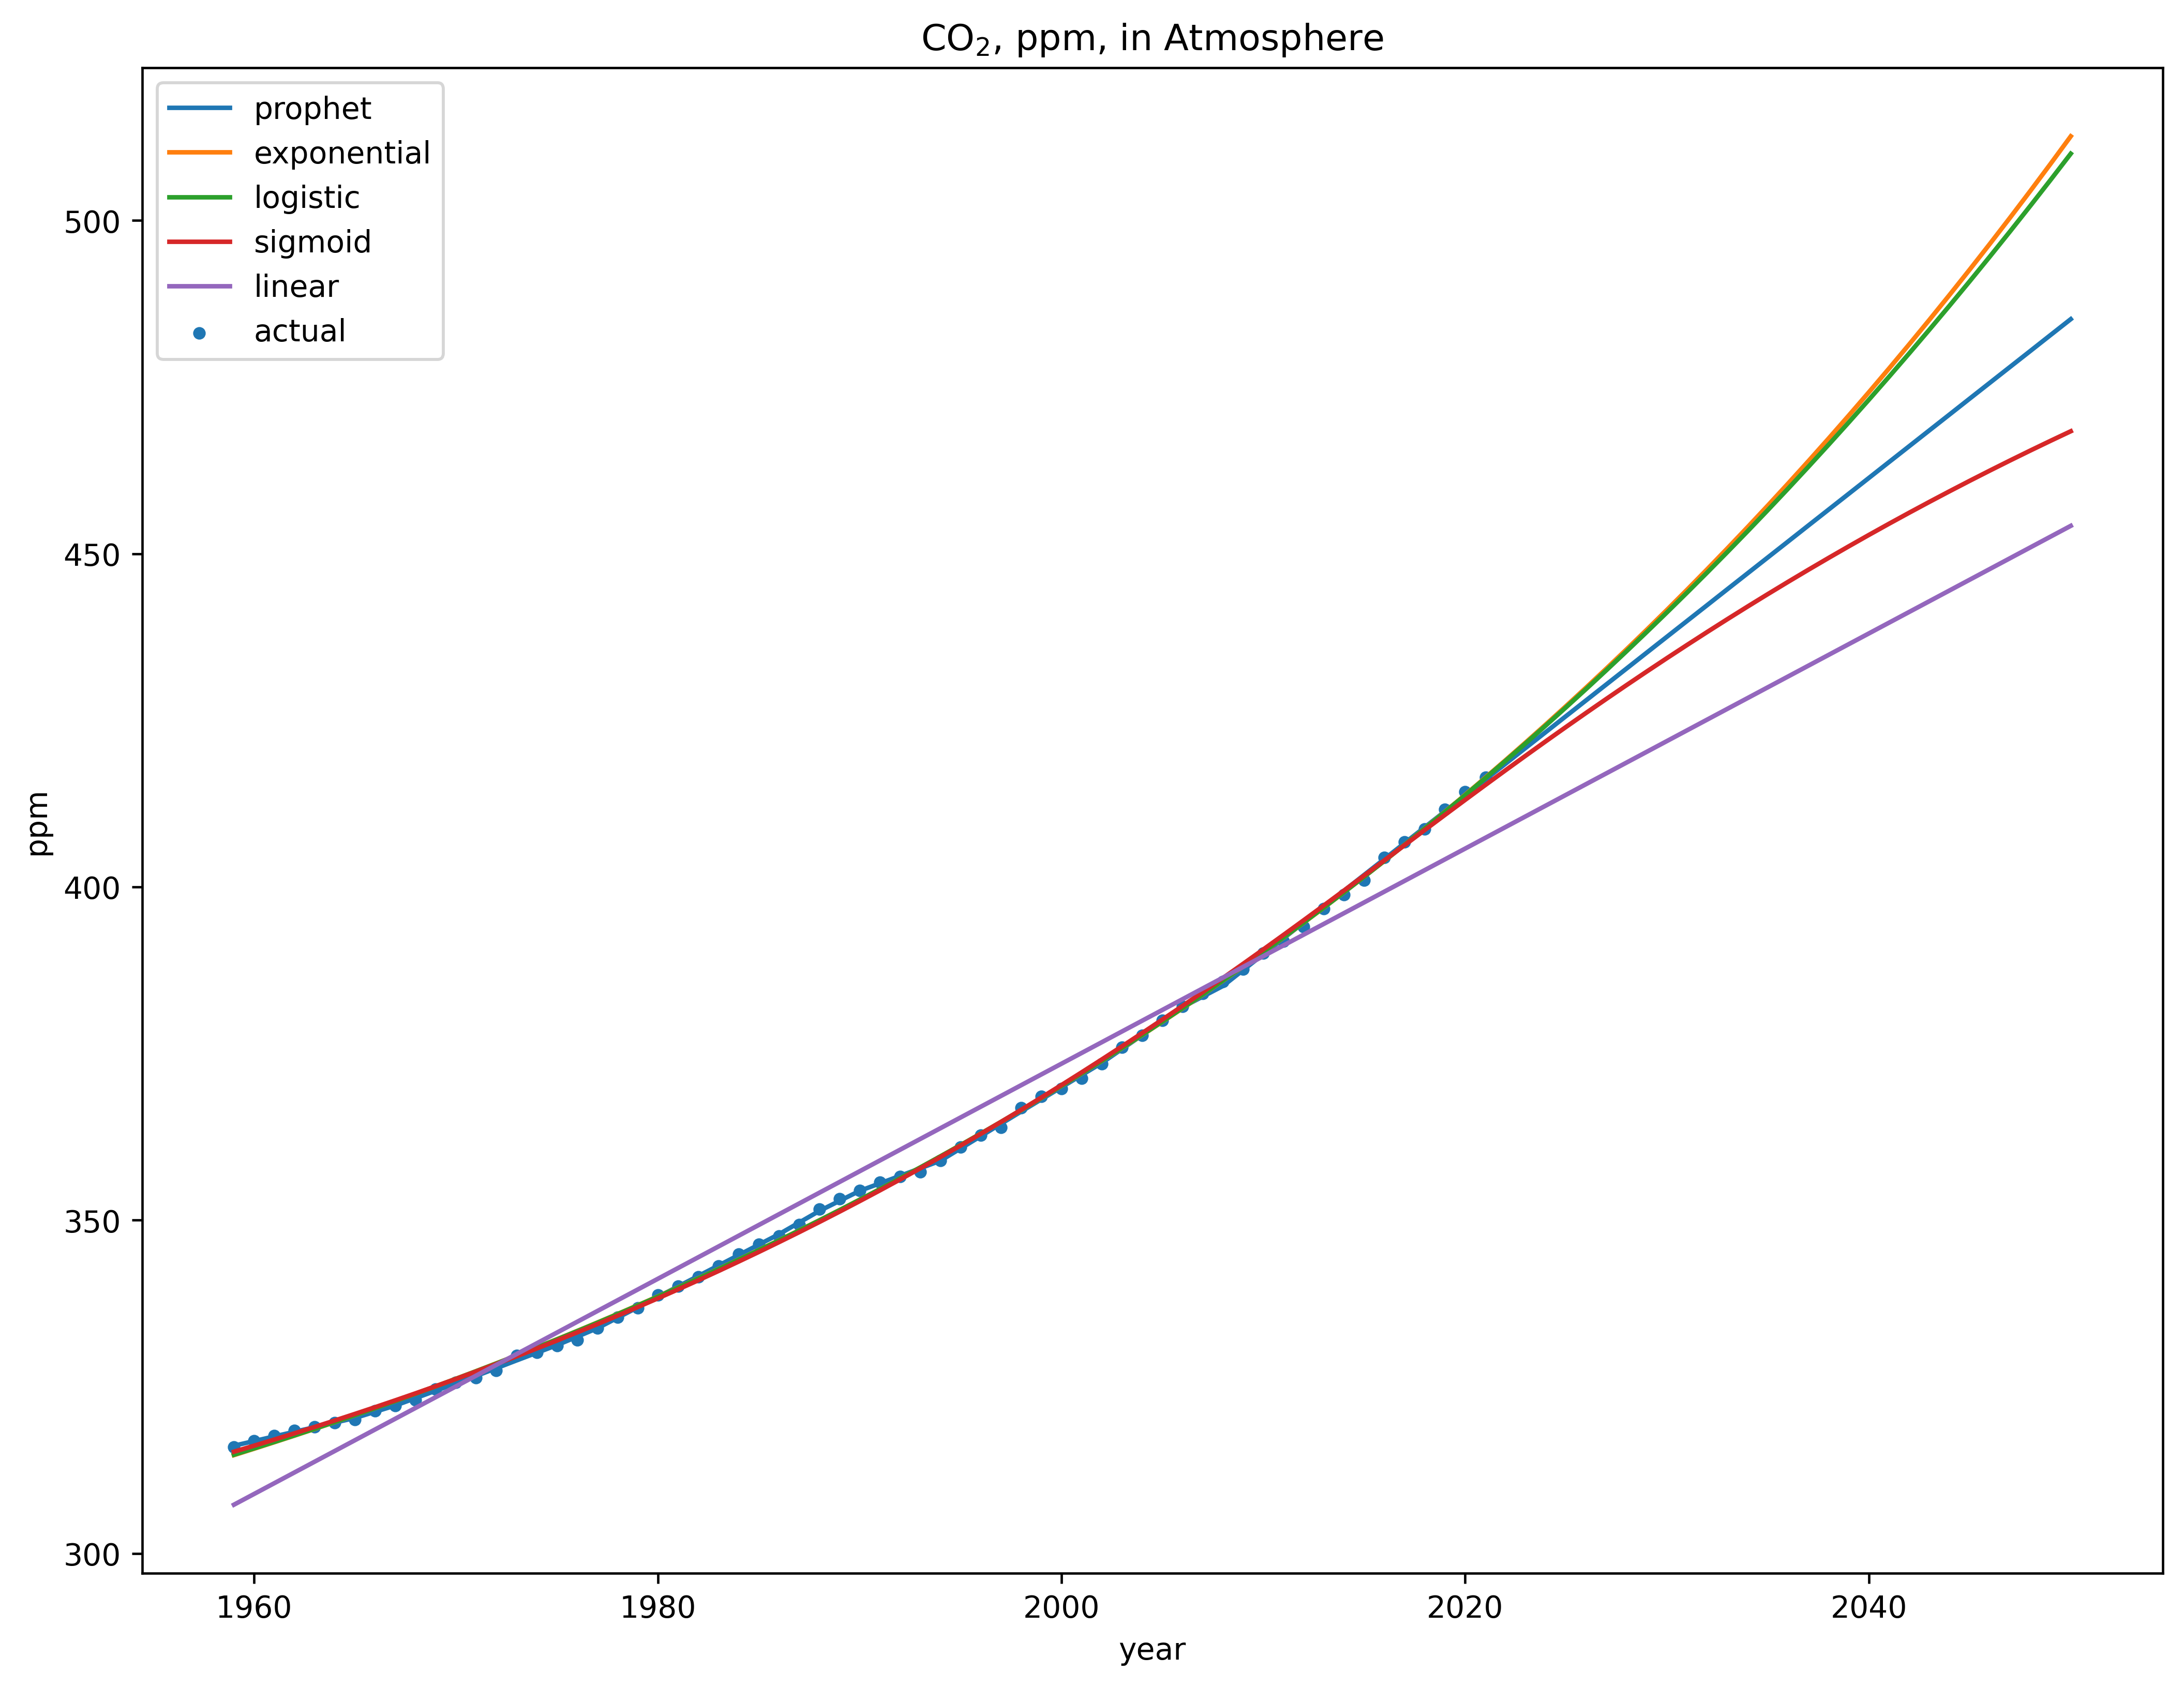

In [54]:
plt.figure(figsize=(12, 9), dpi=420)
plt.plot(PRED_YEARS, co2_pred_prophet, label='prophet')
plt.plot(PRED_YEARS, co2_pred_exp, label='exponential')
plt.plot(PRED_YEARS, co2_pred_logi, label='logistic')
plt.plot(PRED_YEARS, co2_pred_sigm, label='sigmoid')
plt.plot(PRED_YEARS, co2_pred_lr, label='linear')
plt.scatter(co2_df['year'], co2_df['y'], label='actual', s=10)
plt.title('CO$_2$, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend()
plt.show()

In [55]:
PRED_YEARS_MORE_PROPHET = PRED_YEARS_MORE.copy()
PRED_YEARS_MORE_PROPHET.columns = ['ds']
PRED_YEARS_MORE_PROPHET['ds'] = pd.to_datetime(PRED_YEARS_MORE_PROPHET['ds'], format='%Y')

C:\Users\yiqia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


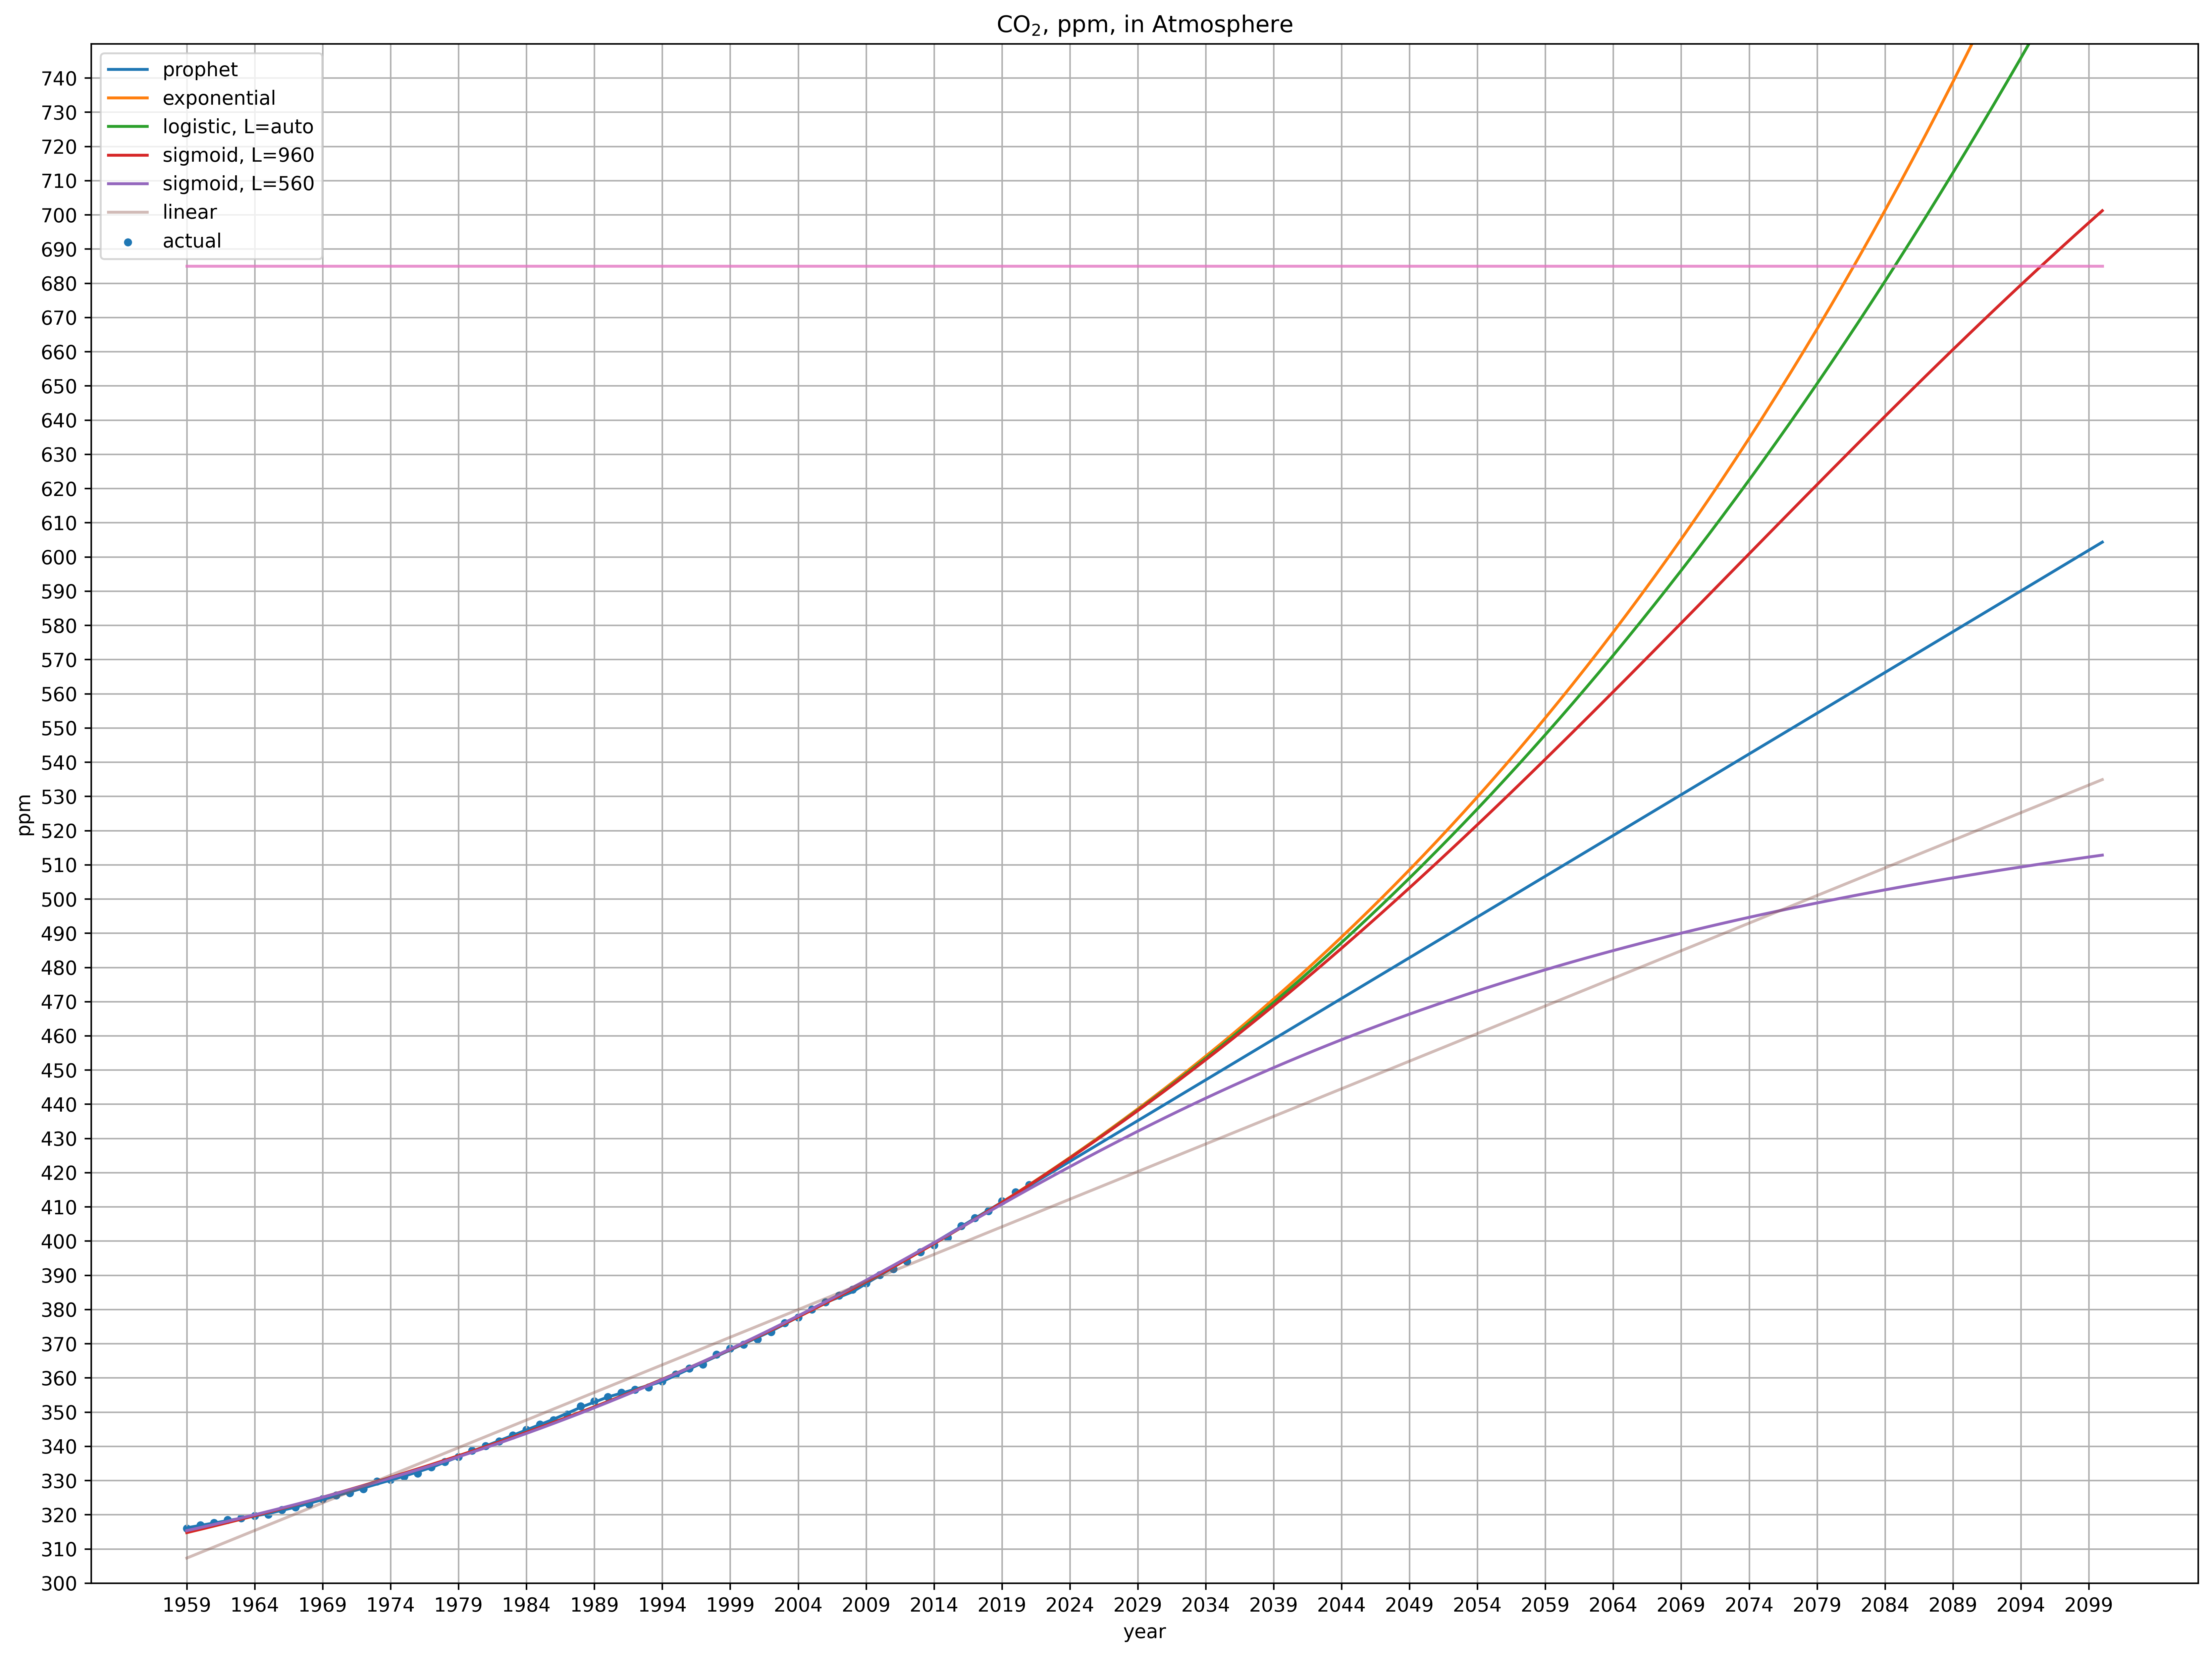

In [80]:
plt.figure(figsize=(16, 12), dpi=420)
plt.plot(PRED_YEARS_MORE, m_co2_P.predict(PRED_YEARS_MORE_PROPHET.copy())['yhat'], label='prophet')
plt.plot(PRED_YEARS_MORE, exp_func(PRED_YEARS_MORE, *pmt_co2_exp), label='exponential')
plt.plot(PRED_YEARS_MORE, logi_func(PRED_YEARS_MORE, *pmt_co2_logi), label='logistic, L=auto')
plt.plot(PRED_YEARS_MORE, sigm_func(PRED_YEARS_MORE, *pmtS_co2_sigm[960]), label='sigmoid, L=960')
plt.plot(PRED_YEARS_MORE, sigm_func(PRED_YEARS_MORE, *pmtS_co2_sigm[560]), label='sigmoid, L=560')
plt.plot(PRED_YEARS_MORE, m_co2_lr.predict(PRED_YEARS_MORE), label='linear', alpha=0.4)
plt.scatter(co2_df['year'], co2_df['y'], label='actual', s=10)
plt.plot(PRED_YEARS_MORE, [685] * len(PRED_YEARS_MORE), alpha=0.8)
plt.title('CO$_2$, ppm, in Atmosphere')
plt.ylabel('ppm')
plt.xlabel('year')
plt.legend(loc='upper left')
plt.grid()
plt.xticks(range(PRED_YEARS_MORE.iloc[0][0], PRED_YEARS_MORE.iloc[-1][0] + 1, 5))
plt.yticks(range(300, int(plt.ylim()[1]), 10))
plt.tight_layout()
plt.savefig('co2_pred_uncrop.png', bbox_inches='tight')
plt.ylim(300, 750)
plt.yticks(range(300, 750, 10))
plt.savefig('co2_pred.png', bbox_inches='tight')
plt.show()

## Temperature Predictions

### Linear

In [82]:
m_lr = LinearRegression()
m_lr.fit(temp_df[['year']], temp_df[['y']])
pmt_temp_lr = m_lr.coef_, m_lr.intercept_

temp_pred_lr = m_lr.predict(PRED_YEARS)
temp_pred_lr = pd.DataFrame(temp_pred_lr)
temp_pred_lr.columns = ['y']

In [58]:
bivariate_stats(temp_df['y'], temp_pred_lr['y'])
error_stats(temp_df['y'], temp_pred_lr[:63])
linear_reg_func(m_lr)

PMCC: 0.9477123036837336 
r^2:  0.8981586105535293 
Cov:  0.09503998934641489
MSE:  0.01060544258324593 
RMSE: 0.10298272953872377 
R^2:  0.8981586105535309 
MAE:  0.0860926616763789 
MAPE: 0.9274768838224801%
Linear Regressed: y = 0.016818356374807986x - 33.117418074756785


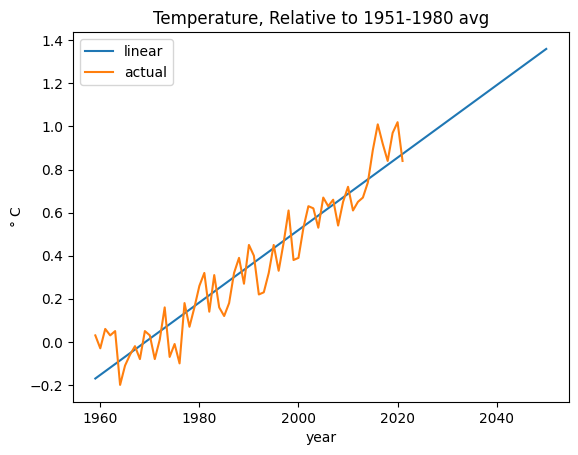

In [59]:
plt.plot(PRED_YEARS, temp_pred_lr, label='linear')
plt.plot(temp_df['year'], temp_df['y'], label='actual')
plt.title('Temperature, Relative to 1951-1980 avg')
plt.ylabel('$\degree$ C')
plt.xlabel('year')
plt.legend()
plt.show()

### Prophet

In [60]:
M3 = temp_df.copy()
M3.columns = ['ds', 'y']
M3['ds'] = pd.to_datetime(M3.ds, format='%Y')

In [61]:
P = Prophet(yearly_seasonality=False)
P.fit(M3)

16:43:35 - cmdstanpy - INFO - Chain [1] start processing
16:43:35 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
temp_forecast_df = P.predict(PRED_YEARS_PROPHET.copy())
temp_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1959-01-01,-0.169525,-0.305795,-0.038031,-0.169525,-0.169525,0.0,0.0,0.0,0.0,0.0,0.0,-0.169525
1,1960-01-01,-0.152765,-0.283964,-0.025702,-0.152765,-0.152765,0.0,0.0,0.0,0.0,0.0,0.0,-0.152765
2,1961-01-01,-0.135959,-0.268794,-0.015015,-0.135959,-0.135959,0.0,0.0,0.0,0.0,0.0,0.0,-0.135959
3,1962-01-01,-0.119199,-0.258504,0.018893,-0.119199,-0.119199,0.0,0.0,0.0,0.0,0.0,0.0,-0.119199
4,1963-01-01,-0.102439,-0.235575,0.026291,-0.102439,-0.102439,0.0,0.0,0.0,0.0,0.0,0.0,-0.102439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2046-01-01,1.294085,1.162359,1.430933,1.293823,1.294335,0.0,0.0,0.0,0.0,0.0,0.0,1.294085
88,2047-01-01,1.310921,1.184289,1.437398,1.310641,1.311183,0.0,0.0,0.0,0.0,0.0,0.0,1.310921
89,2048-01-01,1.327756,1.201833,1.457982,1.327459,1.328033,0.0,0.0,0.0,0.0,0.0,0.0,1.327756
90,2049-01-01,1.344638,1.211694,1.473713,1.344323,1.344926,0.0,0.0,0.0,0.0,0.0,0.0,1.344638


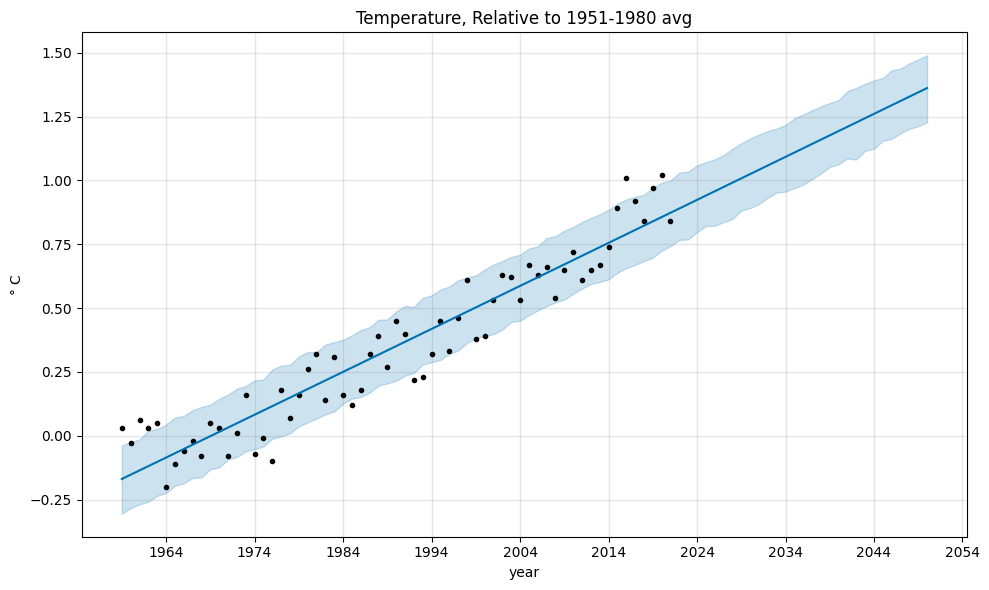

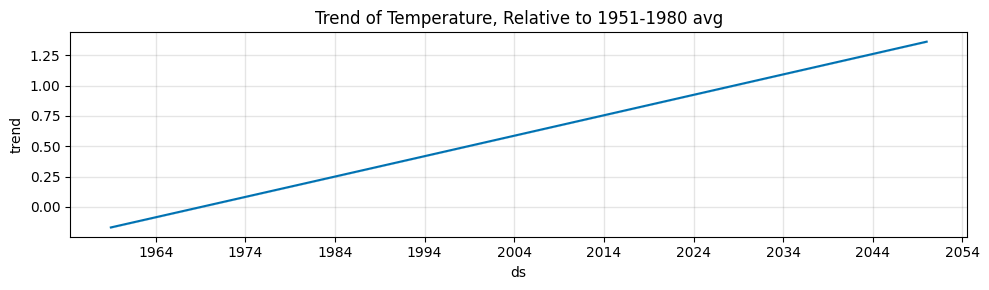

In [63]:
fig3 = P.plot(temp_forecast_df, figsize=(10, 6), xlabel='year', ylabel='$\degree$ C')
fig3.axes[0].set_title('Temperature, Relative to 1951-1980 avg')
fig3.tight_layout()
fig3.savefig('temp_prophet.png', dpi=330)

fig4 = P.plot_components(temp_forecast_df, figsize=(10, 3))
fig4.axes[0].set_title('Trend of Temperature, Relative to 1951-1980 avg')
fig4.tight_layout()
fig4.savefig('temp_trend.png', dpi=330)

In [64]:
temp_pred_prophet = temp_forecast_df[['yhat']]
temp_pred_prophet.columns = ['y']

In [65]:
bivariate_stats(temp_df['y'], temp_pred_prophet['y'])
error_stats(temp_df['y'], temp_pred_prophet['y'][:63])

PMCC: 0.9478492165935094 
r^2:  0.8984181373969296 
Cov:  0.09503428630069044
MSE:  0.010578428895093143 
RMSE: 0.10285148951324498 
R^2:  0.8984180161854938 
MAE:  0.08602790053904663 
MAPE: 0.9258327331604272%


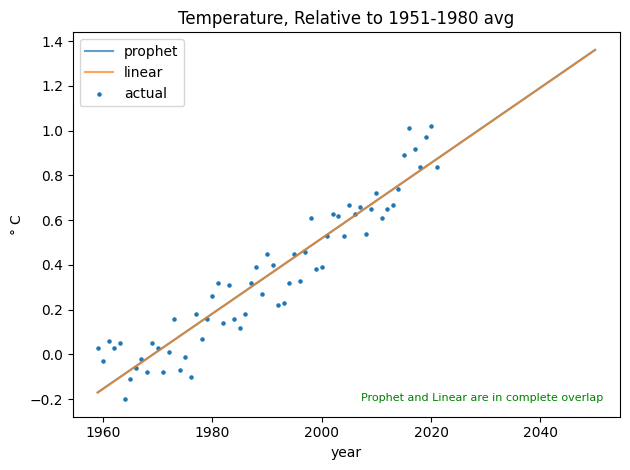

In [66]:
plt.plot(PRED_YEARS, temp_pred_prophet, label='prophet', alpha=0.7)
plt.plot(PRED_YEARS, temp_pred_lr, label='linear', alpha=0.7)
plt.scatter(temp_df['year'], temp_df['y'], s=5, label='actual')
plt.title('Temperature, Relative to 1951-1980 avg')
plt.ylabel('$\degree$ C')
plt.xlabel('year')
plt.legend()
plt.tight_layout()
_ = plt.figure(1, figsize=(8, 6))

plt.figure(1).text(0.95, 0.15, 'Prophet and Linear are in complete overlap',
                   verticalalignment='bottom', horizontalalignment='right',
                   color='green', fontsize=8)
plt.show()

_.savefig('temp_pred.png', bbox_inches='tight', dpi=330)


In [85]:
def reverse_line(y, a, b):
    return (y - b) / a

In [103]:
sigm_func(2095.5, *pmtS_co2_sigm[960])


685.0188790739511

In [70]:
m_lr.predict([[2100]])


C:\Users\yiqia\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[2.20113031]])

In [100]:
exp_func(2081.71, *pmt_co2_exp)


685.0225507004413

In [89]:
print(reverse_line(2.0, *pmt_temp_lr)[0][0])
print(reverse_line(1.75, *pmt_temp_lr)[0][0])
print(reverse_line(1.5, *pmt_temp_lr)[0][0])
print(reverse_line(1.25, *pmt_temp_lr)[0][0])


2088.0410244700693
2073.176313886669
2058.3116033032693
2043.4468927198693


In [104]:
pmt_co2_exp


array([-1.70769063e+03,  2.33806849e-02,  2.56024002e+02])